# PART 3

## 0) IMPORTS

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import CSS4_COLORS
import pandas as pd
from matplotlib.ticker import FuncFormatter
import json
from datetime import datetime, timedelta
from matplotlib import colors
import numpy as np

## 1) PREPROCESSING DATA

### 1.1 - TRANSFORM PODS DATA

In [2]:
# transform json data into txt format
def transform_to_txt(data):
    txt_output = ""
    for item in data["items"][:-1]:
        job_name = item["metadata"]["labels"]["job-name"]
        if job_name != "some-memcached":
            start_time = datetime.strptime(item["status"]["startTime"], "%Y-%m-%dT%H:%M:%SZ")
            end_time = datetime.strptime(item["status"]["containerStatuses"][0]["state"]["terminated"]["finishedAt"], "%Y-%m-%dT%H:%M:%SZ")
            job_time = end_time - start_time
            txt_output += f"Job:  {job_name}\nStart time:  {start_time.strftime('%Y-%m-%d %H:%M:%S')}\nEnd time:  {end_time.strftime('%Y-%m-%d %H:%M:%S')}\nJob time:  {str(job_time)}\n\n"
    return txt_output

with open("./results_3.json", "r") as file:
    json_data = json.load(file)
txt_data = transform_to_txt(json_data)
with open("./data1/run3/pods.txt", "w") as file:
    file.write(txt_data)

FileNotFoundError: [Errno 2] No such file or directory: './results_3.json'

### 1.2 - PREPROCESS MCPERF AND PODS DATA

In [3]:
# utitity functions
def subtract_2_hours(timestamp):
    # what: subtract 2 hours from timestamp
    # why: noticed that mcperf and pods timestamps are off by 2 hours -> solution subtract 2 hours
    return timestamp - timedelta(hours=2)

def read_mcperf_data(folder):
    # what: preprocessing of mcperf data
    mcperf_path = os.path.join('data1', folder, 'mcperf.txt')

    # take only these columns
    columns = ['p95', 'QPS', 'ts_start', 'ts_end']
    df = pd.read_csv(mcperf_path, delim_whitespace=True, usecols=columns)

    # all in seconds
    df['p95'] = df['p95'] / 1000
    df['ts_end'] = df['ts_end']/1000
    df['ts_start'] = df['ts_start']/1000

    # have a timestamp for both start and end (needed for synchronization)
    df['start_timestamp'] = df['ts_start'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0))
    df['end_timestamp'] = df['ts_end'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0))
    df['start_timestamp'] = df['start_timestamp'].apply(subtract_2_hours)
    df['end_timestamp'] = df['end_timestamp'].apply(subtract_2_hours)
    return df

def read_pods_data(folder):
    # what: preprocessing of pods data
    pods_path = os.path.join('data1', folder, 'pods.txt')
    with open(pods_path, 'r') as file:
        lines = file.readlines()
    jobs = []
    start_times = []
    end_times = []
    total_times = []
    abs_start_times = []
    abs_end_times = []
    # since jobs are printed by time, the min start time is the start time of the first job
    min_start_time = pd.to_datetime(lines[1].split(': ')[1].strip())
    for i in range(0, len(lines), 5):
        job_line = lines[i].strip()
        if job_line.startswith("Job:"):
            job = job_line.split(': ')[1].strip()
            # absolute start time = start time in the file
            start_time = pd.to_datetime(lines[i+1].split(': ')[1].strip())
            abs_start_times.append(start_time)

            # absolute end time = end time in the file
            end_time = pd.to_datetime(lines[i+2].split(': ')[1].strip())
            abs_end_times.append(end_time)

            # total time 
            total_time = pd.to_datetime(lines[i+3].split(': ')[1].strip())

            # relative start time = start time wrt min start time in seconds
            start_time = (start_time - min_start_time).total_seconds()

            # relative end time = end time wrt min start time in seconds
            end_time = (end_time - min_start_time).total_seconds()

            jobs.append(job)
            start_times.append(start_time)
            end_times.append(end_time)
            total_times.append(total_time.hour * 3600 + total_time.minute * 60 + total_time.second)
    df = pd.DataFrame({'Job': jobs, 'Start Time': start_times, 'End Time': end_times, 'Tot Time': total_times, 'abs_start_time': abs_start_times, 'abs_end_time': abs_end_times})
    return df

def cut_df(mcperf,pods,run):
    # this function cuts off the parts of the mcperf file(/df) that are not neeeded because they are not relative to the makespan of the jobs
    # notice that first the times are synchronized

    # step 1 - identify the interval of interest
    # min start time of all jobs
    min_time = pods['abs_start_time'].min()
    # max end time of all jobs
    max_time = pods['abs_end_time'].max()

    # step 2 - pick indices of mcperf intervall in which the min start time takes place
    # condition: min start time is greater than the start interval and smaller than the end interval
    indici_pre_min = mcperf.loc[mcperf['start_timestamp'] <= min_time].index
    indici_post_min = mcperf.loc[mcperf['end_timestamp']>=min_time].index
    common_min_indices = set(indici_pre_min).intersection(indici_post_min)
    first_common_min_index = min(common_min_indices)
    
    # step 3 - pick indices of mcperf intervall in which the max end time takes place
    # condition: max end time is greater than the start interval and smaller than the end interval
    indici_pre_max = mcperf.loc[mcperf['start_timestamp'] <= max_time].index
    indici_post_max = mcperf.loc[mcperf['end_timestamp']>=max_time].index
    common_max_indices = set(indici_pre_max).intersection(indici_post_max)
    first_common_max_index = min(common_max_indices)

    # step 4 - we have the first index to consider and the last one, we slice the df accordingly
    if run =='run2':
        sliced_df = mcperf.iloc[first_common_min_index:first_common_max_index+1]
    else:
        sliced_df = mcperf.iloc[first_common_min_index:first_common_max_index]
    dist =  min_time - mcperf.iloc[first_common_min_index]['start_timestamp']
    return sliced_df, dist

# thic contains mcperf data WITHOUT syncrhonization
all_mcperf_data = []
# this contains mcperf data WITH synchronization
all_mcperf_data2=[]
# this contains pods data
all_pods_data = []
# this contains the distance betweeen the min start of the pod and the start of the mcperf interval
distances =[]
for run_folder in ['run1', 'run2', 'run3']:
    mcperf = read_mcperf_data(run_folder)
    pods = read_pods_data(run_folder)
    all_mcperf_data.append(mcperf)
    all_pods_data.append(pods)
    sliced_df, dist = cut_df(mcperf,pods, run_folder)
    all_mcperf_data2.append(sliced_df)
    distances.append(dist)


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/1786769896.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(mcperf_path, delim_whitespace=True, usecols=columns)
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/1786769896.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(mcperf_path, delim_whitespace=True, usecols=columns)
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/1786769896.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(mcperf_path, delim_whitespace=True, usecols=columns)


## 2) TABULAR DATA

In [4]:
# step 1 - compute job's runtime mean and std
pods_combined = pd.concat(all_pods_data)
job_stats = pods_combined.groupby('Job')['Tot Time'].agg(['mean', 'std']).round(2)
job_stats.T

Job,parsec-blackscholes,parsec-canneal,parsec-dedup,parsec-ferret,parsec-freqmine,parsec-radix,parsec-vips
mean,132.33,128.33,19.67,107.67,192.67,13.0,64.00
std,3.21,10.02,9.81,2.08,3.06,1.0,19.92


In [5]:
# step 3 - compute makespan mean and std
makespan_per_run = [pods_data['End Time'].max() for pods_data in all_pods_data]
makespan_df = pd.DataFrame({'Makespan': makespan_per_run})
mean_makespan = makespan_df['Makespan'].mean().round(2)
std_makespan = makespan_df['Makespan'].std().round(2)
print("Mean Makespan:", mean_makespan)
print("Standard Deviation of Makespan:", std_makespan)

Mean Makespan: 197.67
Standard Deviation of Makespan: 7.64


In [6]:
# step 4 - count SLO violations
mcperf_combined = pd.concat(all_mcperf_data)
violation_count = (mcperf_combined['p95'] > 1).sum()
total_data_points = len(mcperf_combined)
slo_violation_ratio = violation_count / total_data_points
print("SLO violation ratio:", slo_violation_ratio)


SLO violation ratio: 0.0


## 3) STATIC SCHEDULING PLOT

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/192438199.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/192438199.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


parsec-canneal
parsec-vips
parsec-freqmine
parsec-ferret
parsec-dedup
parsec-radix
parsec-blackscholes


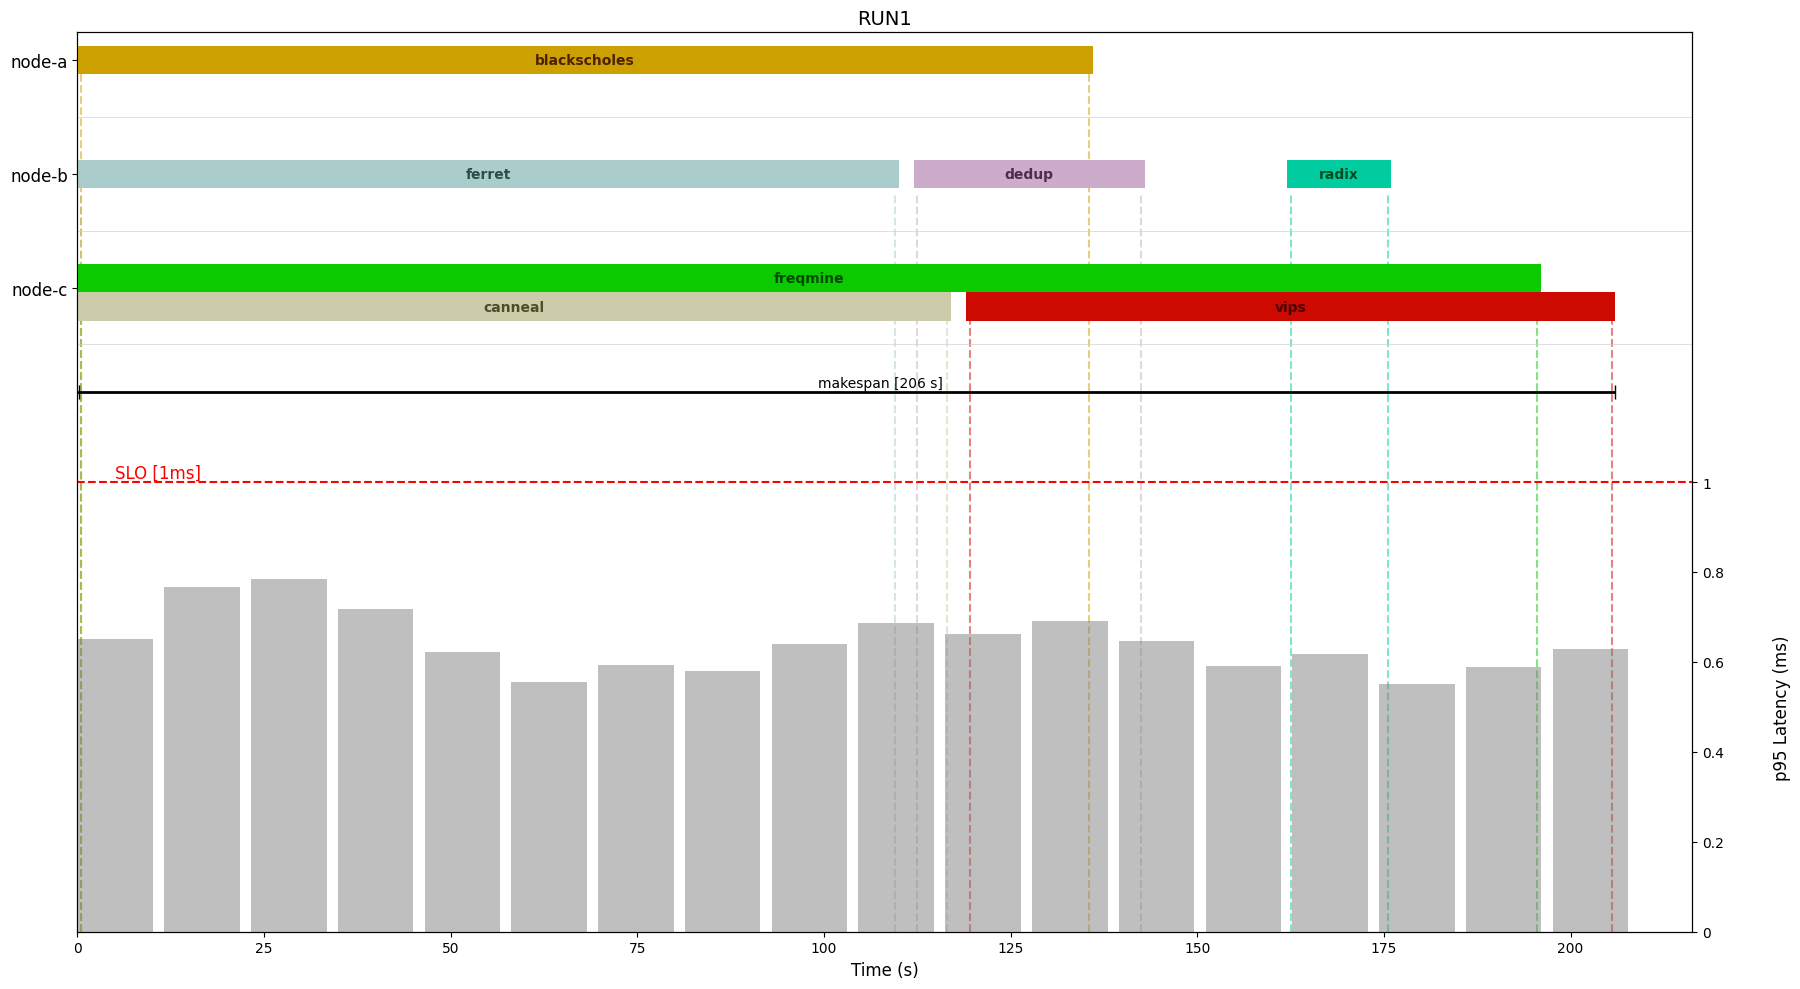

parsec-canneal
parsec-vips
parsec-freqmine
parsec-ferret
parsec-dedup
parsec-radix
parsec-blackscholes


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/192438199.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/192438199.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


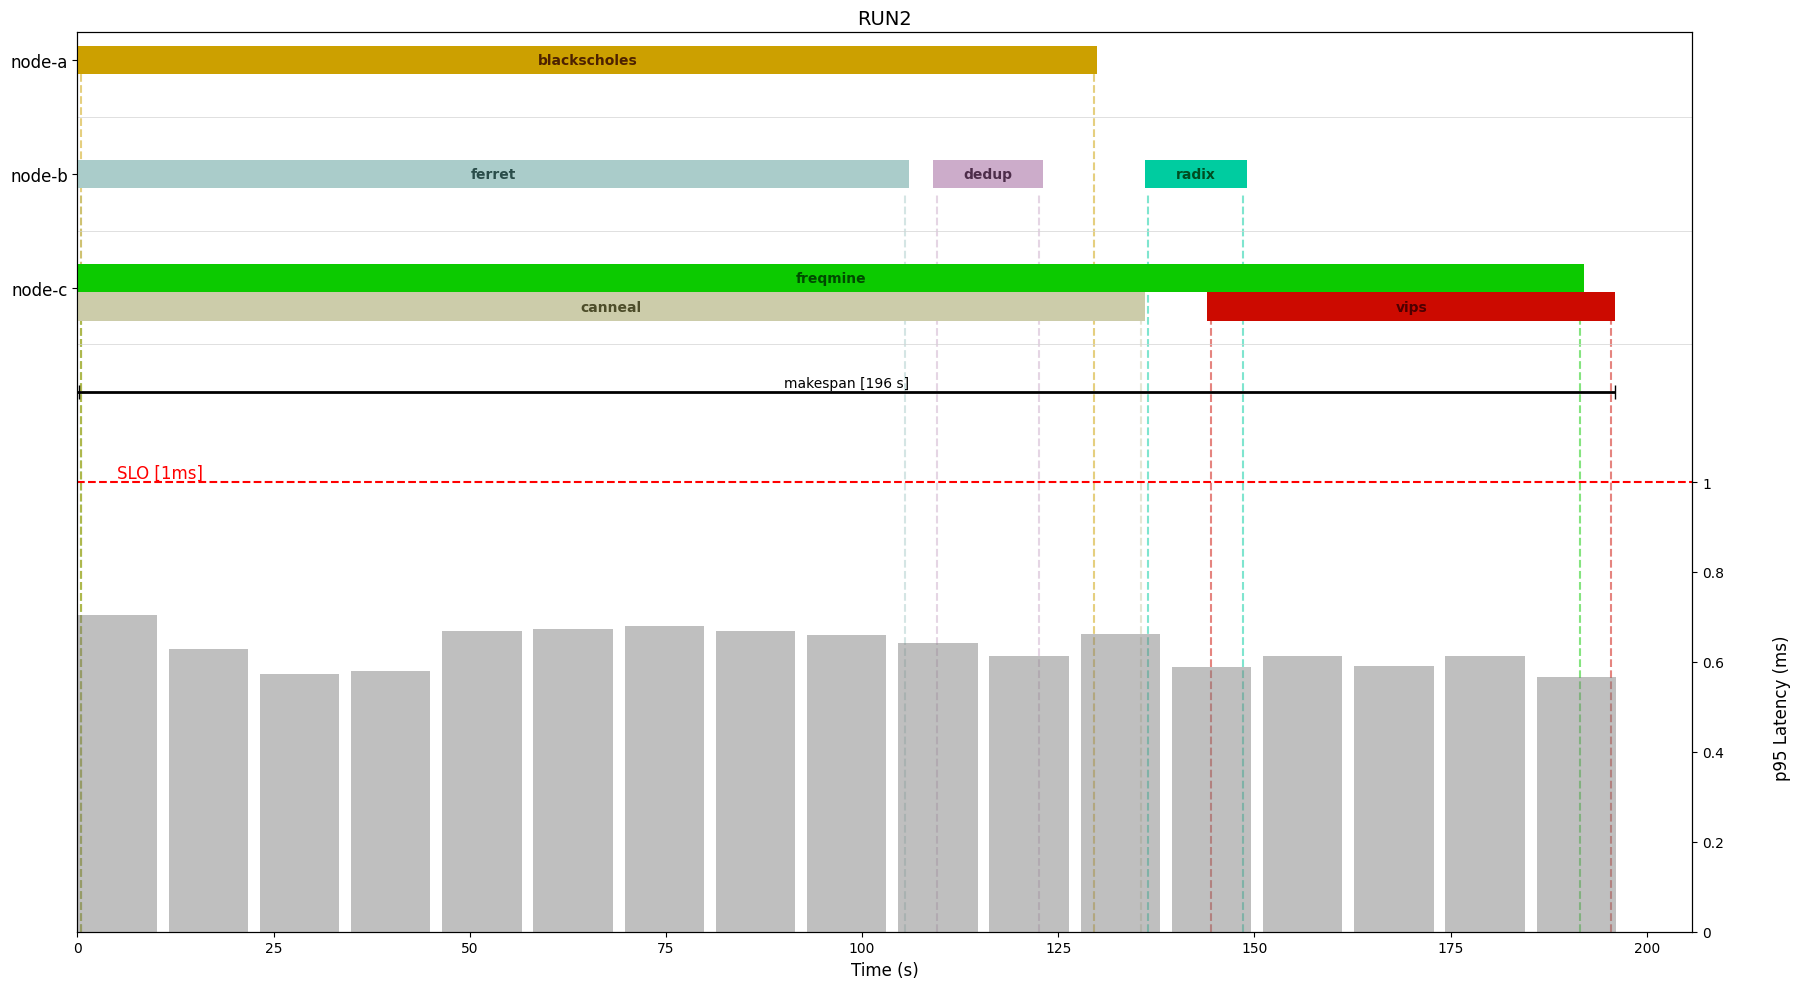

parsec-canneal
parsec-vips
parsec-freqmine
parsec-ferret
parsec-dedup
parsec-radix
parsec-blackscholes


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/192438199.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/192438199.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


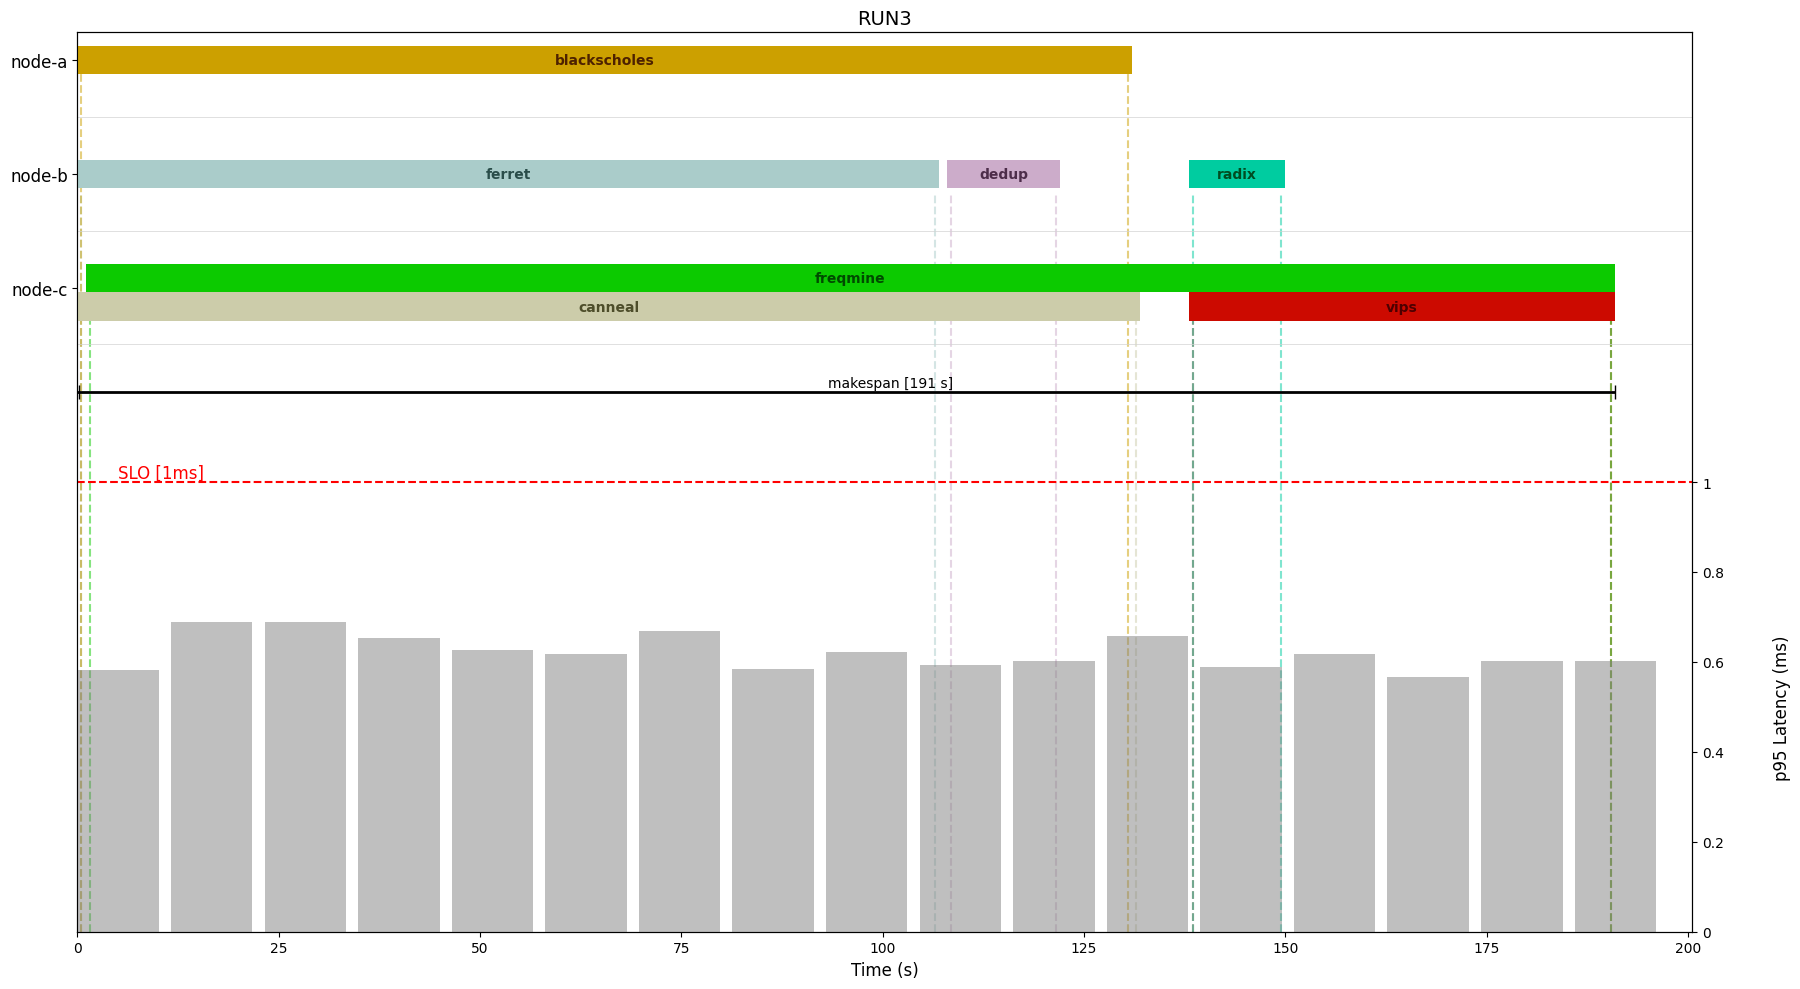

In [ ]:

job_colors = {
    'parsec-blackscholes': '#CCA000',
    'parsec-canneal': '#CCCCAA',
    'parsec-dedup': '#CCACCA',
    'parsec-ferret': '#AACCCA',
    'parsec-freqmine': '#0CCA00',
    'parsec-radix': '#00CCA0',
    'parsec-vips': '#CC0A00'
}
job_lim = {
    'parsec-blackscholes': 0.98,
    'parsec-canneal': 0.68,
    'parsec-dedup': 0.82,
    'parsec-ferret': 0.82,
    'parsec-freqmine': 0.72,
    'parsec-radix': 0.82,
    'parsec-vips': 0.68
}
def darken_color(color):
    # Convert the color to RGB values
    r, g, b = colors.to_rgb(color)

    # Darken the color by reducing each RGB component
    new_r = max(0, r - 0.5)
    new_g = max(0, g - 0.5)
    new_b = max(0, b - 0.5)

    # Create the darker color
    darker_color = (new_r, new_g, new_b)

    return darker_color

def plot_combined_plot(mcperf_df, pods_df, run_folder, dist):
    fig, ax1 = plt.subplots(figsize=(18, 10))

    job_groups = {
        'node-c': ['parsec-canneal', 'parsec-vips','parsec-freqmine'],
        'node-b': ['parsec-ferret', 'parsec-dedup', 'parsec-radix'],
        'node-a': ['parsec-blackscholes'],
    }
    vertical_spacing = 1.0 
    y_positions = {'node-c': 3.0, 'node-b': 10.0, 'node-a': 16.0}
    maxt = 0
    for group_name, group_jobs in job_groups.items():
        for job in group_jobs:
            row = pods_df[pods_df['Job'] == job].iloc[0]
            if row['Job'] in job_colors:
                color = job_colors[row['Job']]
                limit = job_lim[row['Job']]
                print(job)
                if row['End Time'] > maxt:
                    maxt = row['End Time']
                if job[7:]=='freqmine':
                    y_positions[group_name] += 1.5
                ax1.barh(y=y_positions[group_name], left=row['Start Time'], width=row['End Time'] - row['Start Time'], height=1.5, color=color, zorder=3)

                text_x = (row['Start Time'] + row['End Time']) / 2  
                text_y = y_positions[group_name]
                ax1.text(text_x, text_y, job[7:], ha='center', va='center', color=darken_color(color), fontsize=10, fontweight='bold')
                ax1.axvline(x=row['Start Time']+0.5, ymin=0,ymax=limit,color=color, linestyle='--', alpha=0.5)
                ax1.axvline(x=row['End Time']-0.5,  ymin=0,ymax=limit,color=color, linestyle='--', alpha=0.5)

    maxt += 0
    ax1.set_ylim(-30)
    ax1.set_yticks([4.0, 10.0, 16.0])
    ax1.set_yticklabels(list(job_groups.keys()), fontsize=12)

    tray_y_positions = [1.0, 7, 13.0]
    for y_pos in tray_y_positions:
        ax1.axhline(y=y_pos, color='lightgray', linewidth=0.5)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_xlim(0)
    mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
    mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()
    ax2 = ax1.twinx()
    ax2.bar(mcperf_df['left'], mcperf_df['p95'], width=mcperf_df['width'], align='edge', color='grey', alpha=0.5)

    ax2.axhline(y=1, color='red', linestyle='--', label='1 ms')
    if run_folder == 'run3':
        ax2.text(5, 1, 'SLO [1ms]', color='red', fontsize=12, verticalalignment='bottom')
    else:
        ax2.text(5, 1, 'SLO [1ms]', color='red', fontsize=12, verticalalignment='bottom')

    ax2.hlines(y=1.2, xmin=0, xmax=maxt, color='black', linewidth=2 )
    ax2.text((dist.total_seconds() + maxt) / 2, 1.22, f'makespan [{int(maxt)} s]', horizontalalignment='center', verticalalignment='center')

    ax2.plot(0.25, 1.2, marker='|', markersize=10, color='black')
    ax2.plot(maxt, 1.2, marker='|', markersize=10, color='black')
    ax2.set_ylabel('p95 Latency (ms)', fontsize=12)
    ax2.yaxis.set_label_coords(1.05,0.25)
    ax2.set_title(f'{run_folder}'.upper(), fontsize=14)

    ax2.set_ylim(0, 2) 
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
    ax2.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], fontsize=10)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
     


    plt.tight_layout()
    plt.show()

for i, run_folder in enumerate(['run1', 'run2', 'run3']):
    plot_combined_plot(all_mcperf_data2[i], all_pods_data[i], run_folder, distances[i])


## EXTRA

### backpup

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/1843593962.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/1843593962.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


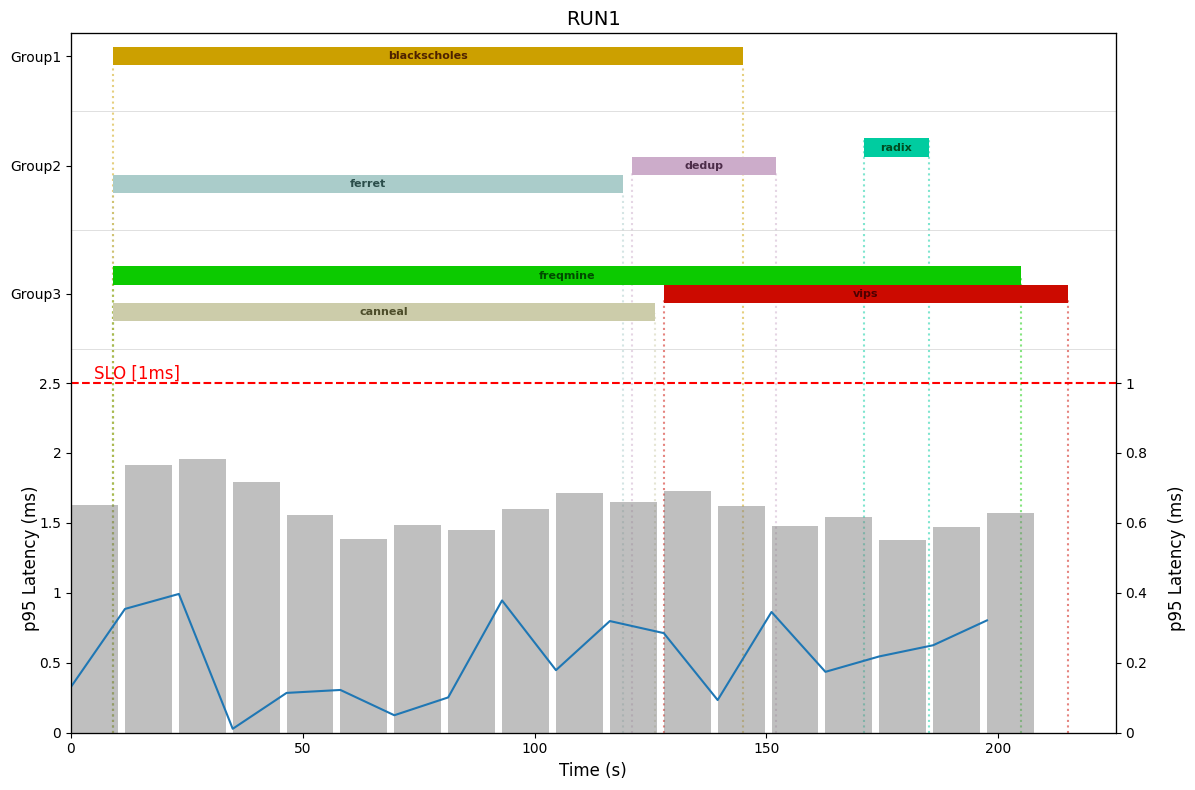

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/1843593962.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/1843593962.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


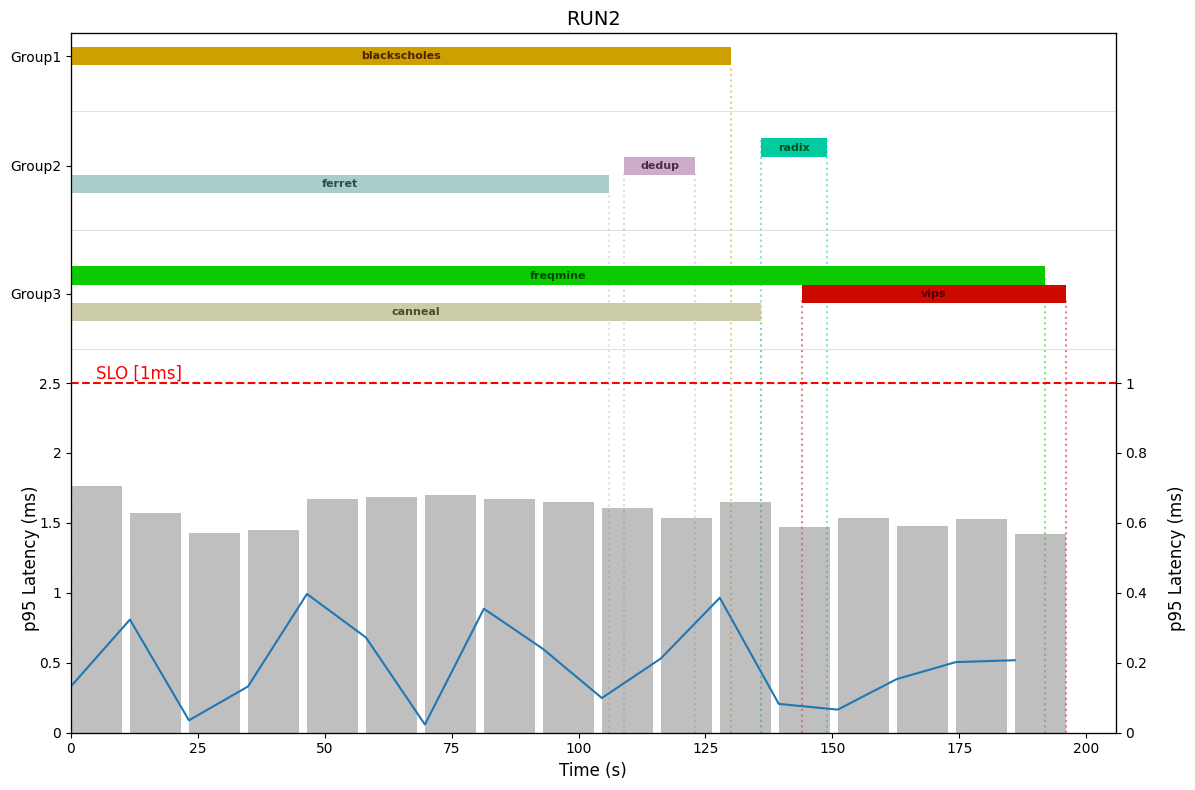

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/1843593962.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/1843593962.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


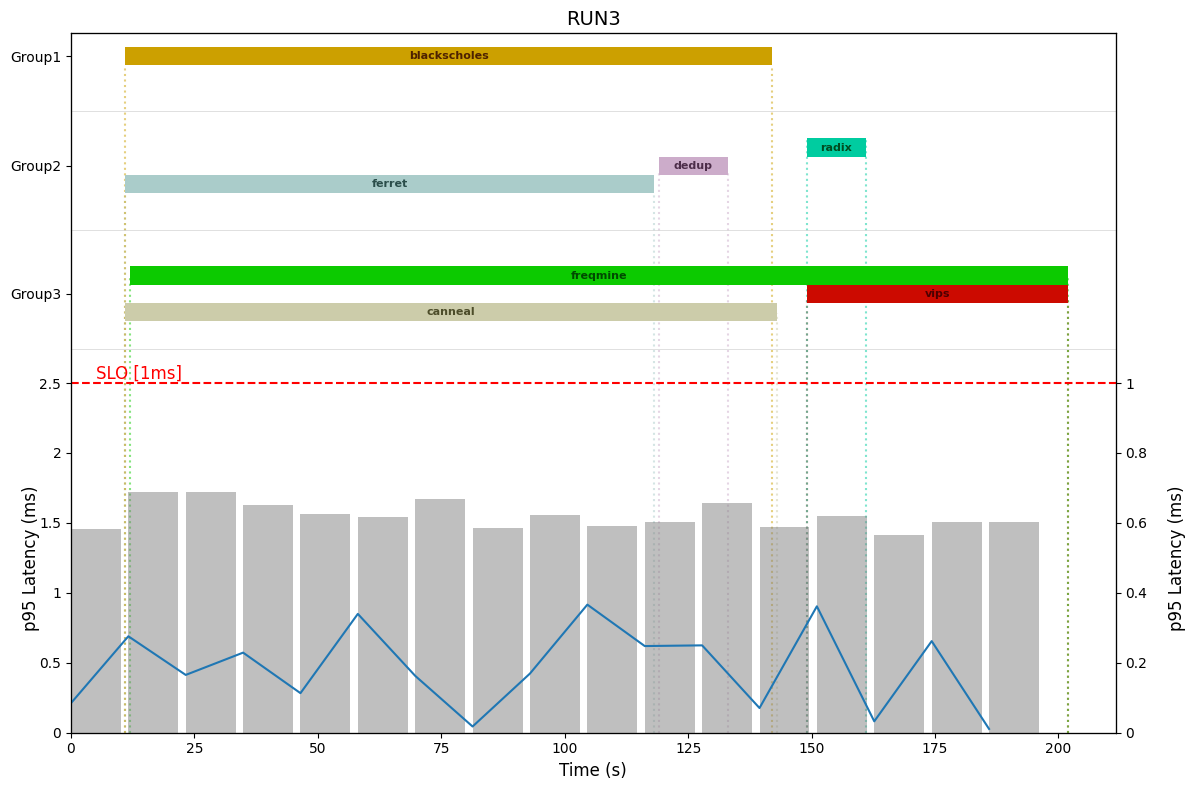

In [8]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

job_colors = {
    'parsec-blackscholes': '#CCA000',
    'parsec-canneal': '#CCCCAA',
    'parsec-dedup': '#CCACCA',
    'parsec-ferret': '#AACCCA',
    'parsec-freqmine': '#0CCA00',
    'parsec-radix': '#00CCA0',
    'parsec-vips': '#CC0A00'
}
job_lim = {
    'parsec-blackscholes': 0.95,
    'parsec-canneal': 0.6,
    'parsec-dedup': 0.8,
    'parsec-ferret': 0.77,
    'parsec-freqmine': 0.65,
    'parsec-radix': 0.85,
    'parsec-vips': 0.62,
    'memcached': 'grey'
}
def darken_color(color):
    # Convert the color to RGB values
    r, g, b = colors.to_rgb(color)

    # Darken the color by reducing each RGB component
    new_r = max(0, r - 0.5)
    new_g = max(0, g - 0.5)
    new_b = max(0, b - 0.5)

    # Create the darker color
    darker_color = (new_r, new_g, new_b)

    return darker_color

def plot_combined_plot(mcperf_df, pods_df, run_folder, dist):
    fig, ax1 = plt.subplots(figsize=(12, 8))

    job_groups = {
        'Group3': ['parsec-canneal', 'parsec-vips','parsec-freqmine'],
        'Group2': ['parsec-ferret', 'parsec-dedup', 'parsec-radix'],
        'Group1': ['parsec-blackscholes'],
    }
    vertical_spacing = 1.0 
    y_positions = {'Group3': 3.0, 'Group2': 10.0, 'Group1': 17.0}
    for group_name, group_jobs in job_groups.items():
        for job in group_jobs:
            row = pods_df[pods_df['Job'] == job].iloc[0]
            if row['Job'] in job_colors:
                color = job_colors[row['Job']]
                limit = job_lim[row['Job']]
                ax1.barh(y=y_positions[group_name], left=row['Start Time']+dist.total_seconds(), width=row['End Time'] - row['Start Time'], height=1, color=color, zorder=3)

                text_x = (row['Start Time']+dist.total_seconds() + row['End Time']+dist.total_seconds()) / 2  
                text_y = y_positions[group_name]
                ax1.text(text_x, text_y, job[7:], ha='center', va='center', color=darken_color(color), fontsize=8, fontweight='bold')
                ax1.axvline(x=row['Start Time']+dist.total_seconds(), ymin=0,ymax=limit,color=color, linestyle=':', alpha=0.5)
                ax1.axvline(x=row['End Time']+dist.total_seconds(),  ymin=0,ymax=limit,color=color, linestyle=':', alpha=0.5)

                y_positions[group_name] += 1 
        

    ax1.set_ylim(-20)
    ax1.set_yticks([4.0, 11.0, 17.0])
    ax1.set_yticklabels(list(job_groups.keys()))

    tray_y_positions = [1.0, 7.5, 14.0]
    for y_pos in tray_y_positions:
        ax1.axhline(y=y_pos, color='lightgray', linewidth=0.5)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_xlim(0)
    mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
    mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()
    ax2 = ax1.twinx()
    ax2.bar(mcperf_df['left'], mcperf_df['p95'], width=mcperf_df['width'], align='edge', color='grey', alpha=0.5)

    ax2.axhline(y=1, color='red', linestyle='--', label='1 ms')
    if run_folder == 'run3':
        ax2.text(5, 1, 'SLO [1ms]', color='red', fontsize=12, verticalalignment='bottom')
    else:
        ax2.text(5, 1, 'SLO [1ms]', color='red', fontsize=12, verticalalignment='bottom')

    ax2.set_ylabel('p95 Latency (ms)', fontsize=12)
    ax2.yaxis.set_label_coords(1.05,0.25)
    ax2.set_title(f'{run_folder}'.upper(), fontsize=14)

    
    ax2.set_ylim(0, 2) 
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
    ax2.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], fontsize=10)
     
    ax3 = ax1.twinx()
    ax3.plot(mcperf_df['left'],np.random.rand(len(mcperf_df['left'])))
    ax3.set_ylim(0, 5) 
    ax3.set_yticks([0, 0.5, 1, 1.5, 2, 2.5]) 
    ax3.set_yticklabels(['0', '0.5', '1', '1.5', '2', '2.5'], fontsize=10) 
    ax3.set_ylabel('p95 Latency (ms)', fontsize=12)
    ax3.yaxis.set_label_position('left')
    ax3.yaxis.set_label_coords(-0.030,0.25)
    ax3.yaxis.tick_left()

    plt.tight_layout()
    plt.show()

for i, run_folder in enumerate(['run1', 'run2', 'run3']):
    plot_combined_plot(all_mcperf_data2[i], all_pods_data[i], run_folder, distances[i])


In [9]:
import json
def subtract_2_hours(timestamp):
    return timestamp - timedelta(hours=2)
def merge_start_finish_times(start_times, finish_times,job, s, e, general,st):
    job['pauses']={}
    start_index = 0
    finish_index = 0
    i = -1
    print(e)
    if len(finish_times)!= len(start_times):
        start_times.insert(0, st)
    while start_index <= len(start_times) and finish_index <= len(finish_times):
        i += 1
        finish_time = finish_times[finish_index]
        print(start_index, len(start_times))
        if start_index == len(start_times):
            print('lllllaaassstttt')
            f = finish_time - general
            f = f.total_seconds()
            job['pauses'][i] = (f, e)
            break
        start_time = start_times[start_index]

        if start_index == 0:
            print('fiiiirstttt')
            staart = start_time - general
            staart = staart.total_seconds()
            job['pauses'][i] = (s, staart)
        if start_index != 0 and start_index != len(start_times):
            print('------------')
            f = finish_time - general
            f = f.total_seconds()
            staart = start_time - general
            staart = staart.total_seconds()
            job['pauses'][i] = (f, staart)
            finish_index += 1
        print('========',start_index, len(start_times), finish_index, len(finish_times))
        start_index += 1
    return job['pauses']


with open('./data4/scheduling/42/1/times_1.json') as file:
    data = json.load(file)

# Extracting job information
total=[]
jobs = {}
mem_to_1 = []
mem_to_2 = []
for job_name, job_data in data.items():
    if job_name == 'total':
        start = datetime.fromtimestamp(float(job_data['start'])).replace(microsecond=0)
        start = subtract_2_hours(start)
        general_s= start
        start = start - general_s
        start = start.total_seconds()
        end = datetime.fromtimestamp(float(job_data['finish'])).replace(microsecond=0)
        end = subtract_2_hours(end)
        end = end - general_s
        end = end.total_seconds()
        total.append(start)
        total.append(end)
    if job_name != 'total' and job_name != 'mem' and job_name != 'cpu' and job_name != 'pauses' and job_name != 'switch_job_1':
        if job_name == 'vips':
            start = datetime.fromtimestamp(float(job_data['start'])).replace(microsecond=0)
            start = subtract_2_hours(start)
            start = start - general_s
            start = start.total_seconds()
            job = {
            'start': start,
            'finish': total[1]
            }
        else:
            start = datetime.fromtimestamp(float(job_data['start'])).replace(microsecond=0)
            start_t = subtract_2_hours(start)
            start = start_t - general_s
            start = start.total_seconds()
            end = datetime.fromtimestamp(float(job_data['finish'])).replace(microsecond=0)
            end_t = subtract_2_hours(end)
            end = end_t - general_s
            end = end.total_seconds()
            job = {
            'start': start,
            'finish': end
            }
            if 'pauses' in job_data:
                pauses = job_data['pauses']
                if 'pause' in pauses:
                    pauses_a = [ datetime.fromtimestamp(float(pause)).replace(microsecond=0) for pause in pauses['pause']]
                    pausess = [ subtract_2_hours(p) for p in pauses_a]
                if 'unpause' in pauses:
                    unpauses_a = [ datetime.fromtimestamp(float(unpause)).replace(microsecond=0) for unpause in pauses['unpause']]
                    unpausess = [ subtract_2_hours(p) for p in unpauses_a]
                job['pauses'] = merge_start_finish_times(pausess, unpausess, job, start, end, general_s, start_t)

        jobs[job_name] = job
    if job_name == 'mem':
        one = job_data['to_1']
        one_a = [ datetime.fromtimestamp(float(o)).replace(microsecond=0) for o in one]
        mem_to_1 = [ subtract_2_hours(o) for o in one_a]
        two = job_data['to_2']
        two_a = [ datetime.fromtimestamp(float(t)).replace(microsecond=0) for t in two]
        mem_to_2 = [ subtract_2_hours(t) for t in two_a]
        

# Printing the extracted information
print("Job Information:")
for job_name, job in jobs.items():
    print(f"{job_name}:")
    print(f"Start Time: {job['start']}")
    print(f"Finish Time: {job['finish']}")
    if 'pauses' in job:
        print("Pauses:")
        for pause_time in job['pauses']:
            print(f"  {pause_time}:", job['pauses'][pause_time])

print("\nMemcached Information:")
print("To 1:", mem_to_1)
print("To 2:", mem_to_2)

mem_df = pd.DataFrame({'timestamp': mem_to_1 + mem_to_2, 'value': [1] * len(mem_to_1) + [2] * len(mem_to_2)})
mem_df.sort_values(by='timestamp', inplace=True)
print(mem_df)



541.0
0 27
fiiiirstttt
======== 0 27 0 27
1 27
------------
======== 1 27 1 27
2 27
------------
======== 2 27 2 27
3 27
------------
======== 3 27 3 27
4 27
------------
======== 4 27 4 27
5 27
------------
======== 5 27 5 27
6 27
------------
======== 6 27 6 27
7 27
------------
======== 7 27 7 27
8 27
------------
======== 8 27 8 27
9 27
------------
======== 9 27 9 27
10 27
------------
======== 10 27 10 27
11 27
------------
======== 11 27 11 27
12 27
------------
======== 12 27 12 27
13 27
------------
======== 13 27 13 27
14 27
------------
======== 14 27 14 27
15 27
------------
======== 15 27 15 27
16 27
------------
======== 16 27 16 27
17 27
------------
======== 17 27 17 27
18 27
------------
======== 18 27 18 27
19 27
------------
======== 19 27 19 27
20 27
------------
======== 20 27 20 27
21 27
------------
======== 21 27 21 27
22 27
------------
======== 22 27 22 27
23 27
------------
======== 23 27 23 27
24 27
------------
======== 24 27 24 27
25 27
------------
======

In [10]:
# step 1 - organize data
import pandas as pd
from datetime import datetime, timedelta
def subtract_2_hours(timestamp):
    return timestamp - timedelta(hours=2)
# 1.1 - mcperf data (take only needed columns)
def read_mcperf_data(folder):
    mcperf_path = os.path.join('data4/scheduling/42', folder, 'mem.txt')
    columns = ['p95', 'QPS', 'ts_start', 'ts_end']
    df = pd.read_csv(mcperf_path, delim_whitespace=True, usecols=columns)
    df['p95'] = df['p95'] / 1000
    df['ts_end'] = df['ts_end']/1000
    df['ts_start'] = df['ts_start']/1000
    df['start_timestamp'] = df['ts_start'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0))
    df['end_timestamp'] = df['ts_end'].apply(lambda x: datetime.fromtimestamp(x).replace(microsecond=0))
    df['start_timestamp'] = df['start_timestamp'].apply(subtract_2_hours)
    df['end_timestamp'] = df['end_timestamp'].apply(subtract_2_hours)
    print(folder)
    print(df)
    return df

# 1.2 - pods data (transform timestamps into seconds, relevanr data)
def read_pods_data(folder):
    pods_path = os.path.join('data1', folder, 'pods.txt')
    with open(pods_path, 'r') as file:
        lines = file.readlines()
    jobs = []
    start_times = []
    end_times = []
    total_times = []
    abs_start_times = []
    abs_end_times = []
    
    min_start_time = pd.to_datetime(lines[1].split(': ')[1].strip())
    for i in range(0, len(lines), 4):
        job_line = lines[i].strip()
        if job_line.startswith("Job:"):
            start_time = pd.to_datetime(lines[i+1].split(': ')[1].strip())
            min_start_time = min(min_start_time, start_time)
    
    for i in range(0, len(lines), 5):
        job_line = lines[i].strip()
        if job_line.startswith("Job:"):
            job = job_line.split(': ')[1].strip()
            start_time = pd.to_datetime(lines[i+1].split(': ')[1].strip())
            abs_start_times.append(start_time)
            end_time = pd.to_datetime(lines[i+2].split(': ')[1].strip())
            abs_end_times.append(end_time)
            total_time = pd.to_datetime(lines[i+3].split(': ')[1].strip())

            start_time = (start_time - min_start_time).total_seconds()
            end_time = (end_time - min_start_time).total_seconds()
            jobs.append(job)
            start_times.append(start_time)
            end_times.append(end_time)
            total_times.append(total_time.hour * 3600 + total_time.minute * 60 + total_time.second)
    df = pd.DataFrame({'Job': jobs, 'Start Time': start_times, 'End Time': end_times, 'Tot Time': total_times, 'abs_start_time': abs_start_times, 'abs_end_time': abs_end_times})
    return df

def cut_df(mcperf,pods):
    min_time = pods['abs_start_time'].min()
    max_time = pods['abs_end_time'].max()
    print(min_time)

    indici_pre_min = mcperf.loc[mcperf['start_timestamp'] <= min_time].index
    print(indici_pre_min)
    indici_post_min = mcperf.loc[mcperf['end_timestamp']>=min_time].index
    print(indici_post_min)
    common_min_indices = set(indici_pre_min).intersection(indici_post_min)
    first_common_min_index = min(common_min_indices)

    indici_pre_max = mcperf.loc[mcperf['start_timestamp'] <= max_time].index
    indici_post_max = mcperf.loc[mcperf['end_timestamp']>=max_time].index
    common_max_indices = set(indici_pre_max).intersection(indici_post_max)
    first_common_max_index = min(common_max_indices)
    sliced_df = mcperf.iloc[first_common_min_index:first_common_max_index + 1]
    dist =  min_time - mcperf.iloc[first_common_min_index]['start_timestamp']
    print(dist)
    return sliced_df, dist


all_mcperf_data = []
all_mcperf_data2=[]
all_pods_data = []
distances =[]
for run_folder in ['1', '2', '3']:
    mcperf = read_mcperf_data(run_folder)
    pods = read_pods_data(run_folder)
    all_mcperf_data.append(mcperf)
    all_pods_data.append(pods)
    sliced_df, dist = cut_df(mcperf,pods)
    all_mcperf_data2.append(sliced_df)
    distances.append(dist)


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_59403/3230492405.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(mcperf_path, delim_whitespace=True, usecols=columns)


ValueError: Usecols do not match columns, columns expected but not found: ['p95', 'ts_start', 'ts_end', 'QPS']

{'start': 0.0, 'finish': 189.0}
0.0
{'start': 190.0, 'finish': 448.0}
190.0
{'start': 449.0, 'finish': 550.0}
449.0
{'start': 449.0, 'finish': 716.0}
449.0
{'start': 0.0, 'finish': 541.0, 'pauses': {0: (0.0, 0.0), 1: (4.0, 7.0), 2: (9.0, 11.0), 3: (45.0, 46.0), 4: (50.0, 50.0), 5: (83.0, 86.0), 6: (88.0, 91.0), 7: (93.0, 94.0), 8: (138.0, 138.0), 9: (147.0, 151.0), 10: (177.0, 177.0), 11: (180.0, 181.0), 12: (227.0, 227.0), 13: (234.0, 235.0), 14: (237.0, 238.0), 15: (240.0, 240.0), 16: (252.0, 252.0), 17: (254.0, 255.0), 18: (257.0, 258.0), 19: (263.0, 271.0), 20: (329.0, 329.0), 21: (394.0, 395.0), 22: (397.0, 398.0), 23: (447.0, 448.0), 24: (515.0, 516.0), 25: (521.0, 521.0), 26: (533.0, 533.0), 27: (539.0, 541.0)}}
0.0
{'start': 542.0, 'finish': 728.0, 'pauses': {0: (542.0, 545.0), 1: (545.0, 547.0), 2: (547.0, 561.0), 3: (559.0, 600.0), 4: (600.0, 625.0), 5: (625.0, 627.0), 6: (627.0, 647.0), 7: (646.0, 657.0), 8: (656.0, 662.0), 9: (661.0, 681.0), 10: (671.0, 707.0), 11: (707.0, 

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3546693186.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3546693186.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


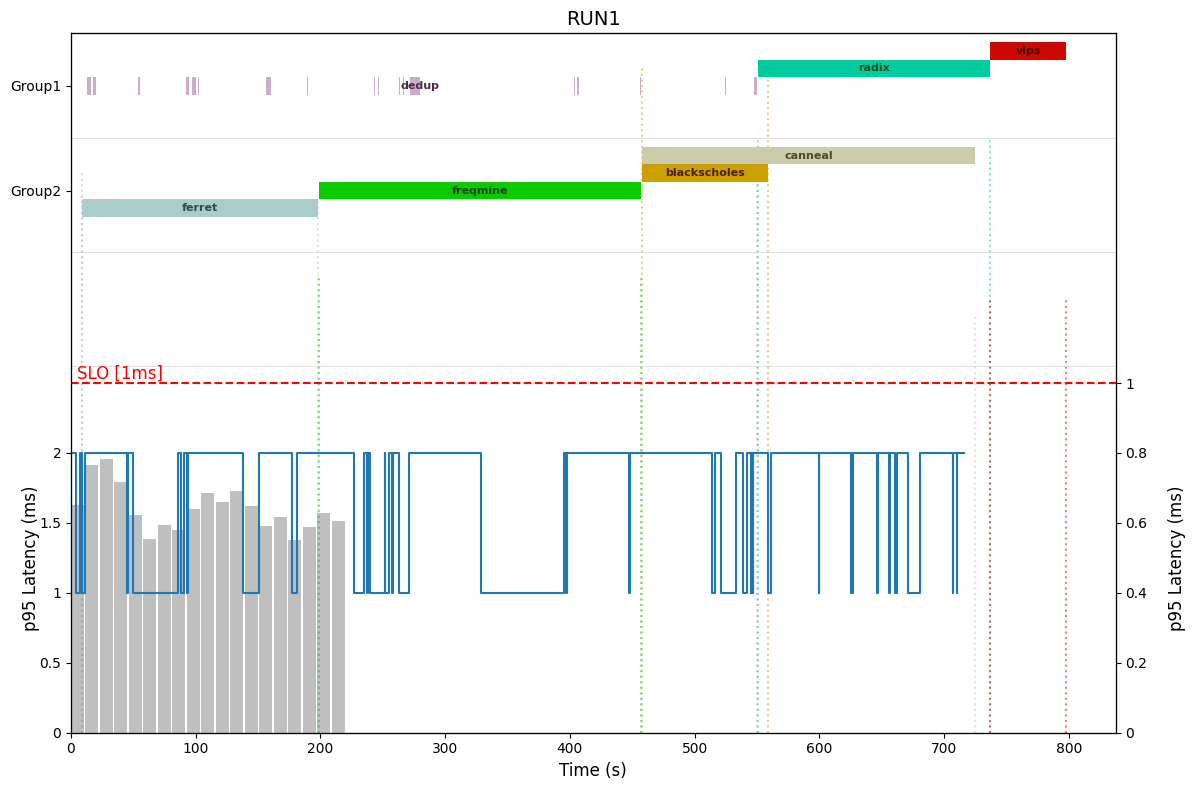

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3546693186.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3546693186.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


{'start': 0.0, 'finish': 189.0}
0.0
{'start': 190.0, 'finish': 448.0}
190.0
{'start': 449.0, 'finish': 550.0}
449.0
{'start': 449.0, 'finish': 716.0}
449.0
{'start': 0.0, 'finish': 541.0, 'pauses': {0: (0.0, 0.0), 1: (4.0, 7.0), 2: (9.0, 11.0), 3: (45.0, 46.0), 4: (50.0, 50.0), 5: (83.0, 86.0), 6: (88.0, 91.0), 7: (93.0, 94.0), 8: (138.0, 138.0), 9: (147.0, 151.0), 10: (177.0, 177.0), 11: (180.0, 181.0), 12: (227.0, 227.0), 13: (234.0, 235.0), 14: (237.0, 238.0), 15: (240.0, 240.0), 16: (252.0, 252.0), 17: (254.0, 255.0), 18: (257.0, 258.0), 19: (263.0, 271.0), 20: (329.0, 329.0), 21: (394.0, 395.0), 22: (397.0, 398.0), 23: (447.0, 448.0), 24: (515.0, 516.0), 25: (521.0, 521.0), 26: (533.0, 533.0), 27: (539.0, 541.0)}}
0.0
{'start': 542.0, 'finish': 728.0, 'pauses': {0: (542.0, 545.0), 1: (545.0, 547.0), 2: (547.0, 561.0), 3: (559.0, 600.0), 4: (600.0, 625.0), 5: (625.0, 627.0), 6: (627.0, 647.0), 7: (646.0, 657.0), 8: (656.0, 662.0), 9: (661.0, 681.0), 10: (671.0, 707.0), 11: (707.0, 

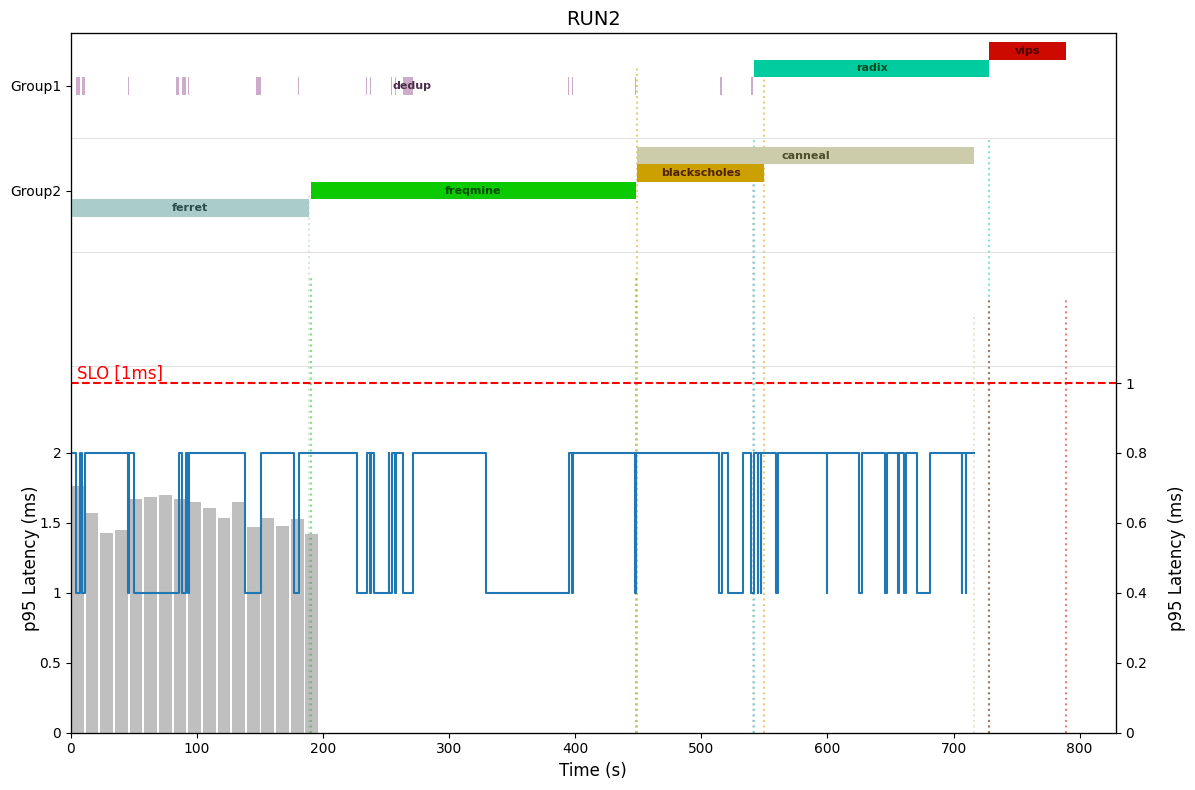

{'start': 0.0, 'finish': 189.0}
0.0
{'start': 190.0, 'finish': 448.0}
190.0
{'start': 449.0, 'finish': 550.0}
449.0
{'start': 449.0, 'finish': 716.0}
449.0
{'start': 0.0, 'finish': 541.0, 'pauses': {0: (0.0, 0.0), 1: (4.0, 7.0), 2: (9.0, 11.0), 3: (45.0, 46.0), 4: (50.0, 50.0), 5: (83.0, 86.0), 6: (88.0, 91.0), 7: (93.0, 94.0), 8: (138.0, 138.0), 9: (147.0, 151.0), 10: (177.0, 177.0), 11: (180.0, 181.0), 12: (227.0, 227.0), 13: (234.0, 235.0), 14: (237.0, 238.0), 15: (240.0, 240.0), 16: (252.0, 252.0), 17: (254.0, 255.0), 18: (257.0, 258.0), 19: (263.0, 271.0), 20: (329.0, 329.0), 21: (394.0, 395.0), 22: (397.0, 398.0), 23: (447.0, 448.0), 24: (515.0, 516.0), 25: (521.0, 521.0), 26: (533.0, 533.0), 27: (539.0, 541.0)}}
0.0
{'start': 542.0, 'finish': 728.0, 'pauses': {0: (542.0, 545.0), 1: (545.0, 547.0), 2: (547.0, 561.0), 3: (559.0, 600.0), 4: (600.0, 625.0), 5: (625.0, 627.0), 6: (627.0, 647.0), 7: (646.0, 657.0), 8: (656.0, 662.0), 9: (661.0, 681.0), 10: (671.0, 707.0), 11: (707.0, 

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3546693186.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3546693186.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


             timestamp  value   plot
39 2024-05-07 11:59:31      2    0.0
0  2024-05-07 11:59:35      1    4.0
40 2024-05-07 11:59:38      2    7.0
1  2024-05-07 11:59:40      1    9.0
41 2024-05-07 11:59:42      2   11.0
..                 ...    ...    ...
37 2024-05-07 12:11:18      1  707.0
77 2024-05-07 12:11:18      2  707.0
38 2024-05-07 12:11:21      1  710.0
78 2024-05-07 12:11:21      2  710.0
79 2024-05-07 12:11:27      2  716.0

[80 rows x 3 columns]


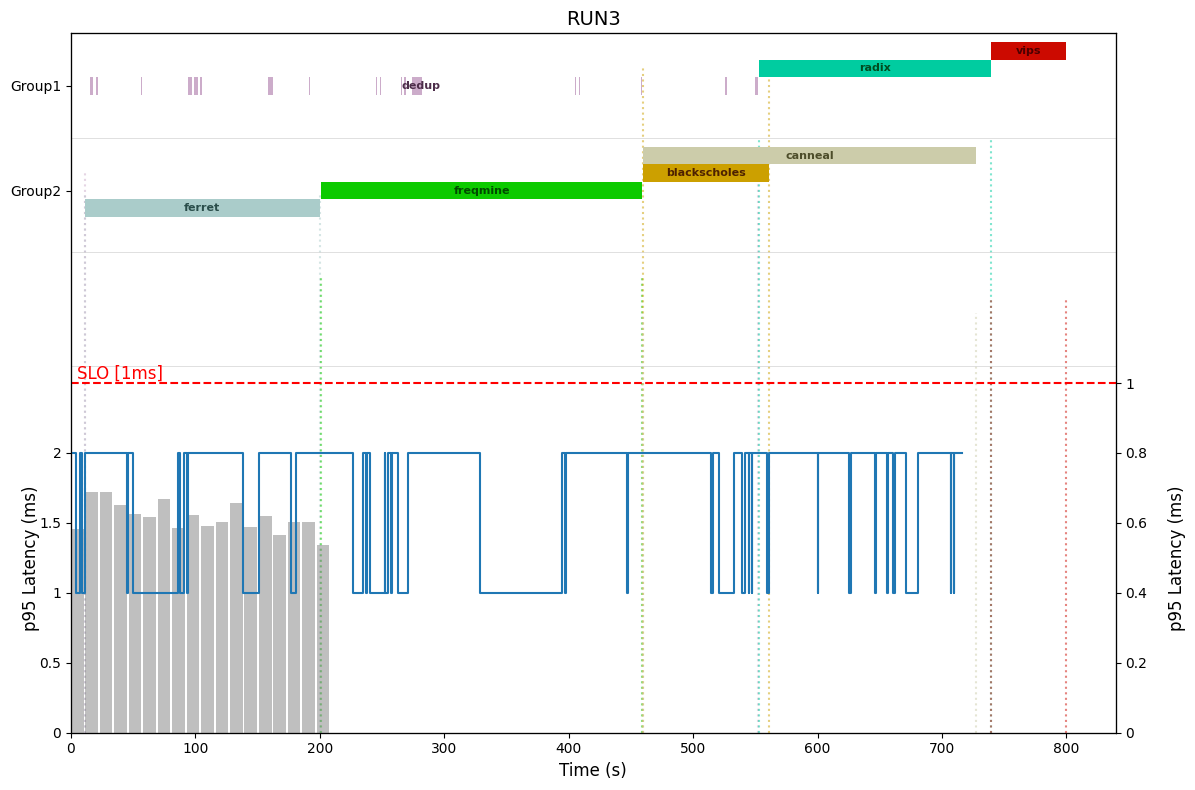

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

job_colors = {
    'parsec-blackscholes': '#CCA000',
    'parsec-canneal': '#CCCCAA',
    'parsec-dedup': '#CCACCA',
    'parsec-ferret': '#AACCCA',
    'parsec-freqmine': '#0CCA00',
    'parsec-radix': '#00CCA0',
    'parsec-vips': '#CC0A00'
}
job_lim = {
    'parsec-blackscholes': 0.95,
    'parsec-canneal': 0.6,
    'parsec-dedup': 0.8,
    'parsec-ferret': 0.77,
    'parsec-freqmine': 0.65,
    'parsec-radix': 0.85,
    'parsec-vips': 0.62,
    'memcached': 'grey'
}
def darken_color(color):
    # Convert the color to RGB values
    r, g, b = colors.to_rgb(color)

    # Darken the color by reducing each RGB component
    new_r = max(0, r - 0.5)
    new_g = max(0, g - 0.5)
    new_b = max(0, b - 0.5)

    # Create the darker color
    darker_color = (new_r, new_g, new_b)

    return darker_color

def plot_combined_plot(mcperf_df, pods_df, run_folder, dist, jobs):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    j = jobs.items()

    job_groups = {
        'Group2': ['parsec-ferret', 'parsec-freqmine', 'parsec-blackscholes', 'parsec-canneal'],
        'Group1': ['parsec-dedup','parsec-radix','parsec-vips',]
    }
    vertical_spacing = 1.0 
    y_positions = {'Group2': 10.0, 'Group1': 17.0}
    for group_name, group_jobs in job_groups.items():
        for job in group_jobs:
            row = pods_df[pods_df['Job'] == job].iloc[0]
            if row['Job'] in job_colors:
                color = job_colors[row['Job']]
                limit = job_lim[row['Job']]
                j = job[7:]
                if j == 'blackscholes':
                    j = 'black'
                jj = jobs[j]
                print(jj)
                print(jj['start'])
                if 'pauses' in jj:
                    pauses = jj['pauses']
                    for el in pauses:
                        e = pauses[el]
                        s = e[0]
                        f = e[1]
                        ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)
                else:
                    s = jj['start']
                    f = jj['finish']
                    ax1.barh(y=y_positions[group_name], left=s+dist.total_seconds(), width=f - s, height=1, color=color, zorder=3)

                text_x = (jj['start']+dist.total_seconds() + jj['finish']+dist.total_seconds()) / 2  
                text_y = y_positions[group_name]
                ax1.text(text_x, text_y, job[7:], ha='center', va='center', color=darken_color(color), fontsize=8, fontweight='bold')
                ax1.axvline(x=jj['start']+dist.total_seconds(), ymin=0,ymax=limit,color=color, linestyle=':', alpha=0.5)
                ax1.axvline(x=jj['finish']+dist.total_seconds(),  ymin=0,ymax=limit,color=color, linestyle=':', alpha=0.5)

                y_positions[group_name] += 1 
        

    ax1.set_ylim(-20)
    ax1.set_yticks([11.0, 17.0])
    ax1.set_yticklabels(list(job_groups.keys()))

    tray_y_positions = [1.0, 7.5, 14.0]
    for y_pos in tray_y_positions:
        ax1.axhline(y=y_pos, color='lightgray', linewidth=0.5)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_xlim((0))
   

    mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
    mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()
    ax2 = ax1.twinx()
    ax2.bar(mcperf_df['left'], mcperf_df['p95'], width=mcperf_df['width'], align='edge', color='grey', alpha=0.5)

    ax2.axhline(y=1, color='red', linestyle='--', label='1 ms')
    if run_folder == 'run3':
        ax2.text(5, 1, 'SLO [1ms]', color='red', fontsize=12, verticalalignment='bottom')
    else:
        ax2.text(5, 1, 'SLO [1ms]', color='red', fontsize=12, verticalalignment='bottom')

    ax2.set_ylabel('p95 Latency (ms)', fontsize=12)
    ax2.yaxis.set_label_coords(1.05,0.25)
    ax2.set_title(f'{run_folder}'.upper(), fontsize=14)

    
    ax2.set_ylim(0, 2) 
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
    ax2.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], fontsize=10)
     
    ax3 = ax1.twinx()
    mem_df['plot'] = mem_df['timestamp'] - pd.Timestamp(general_s)
    mem_df['plot'] = mem_df['plot'].dt.total_seconds()
    print(mem_df)
    ax3.step(mem_df['plot'], mem_df['value'],where='post')
    ax3.set_ylim(0, 5) 
    ax3.set_yticks([0, 0.5, 1, 1.5, 2]) 
    ax3.set_yticklabels(['0', '0.5', '1', '1.5', '2'], fontsize=10) 
    ax3.set_ylabel('p95 Latency (ms)', fontsize=12)
    ax3.yaxis.set_label_position('left')
    ax3.yaxis.set_label_coords(-0.030,0.25)
    ax3.yaxis.tick_left()

    plt.tight_layout()
    plt.show()

for i, run_folder in enumerate(['run1', 'run2', 'run3']):
    plot_combined_plot(all_mcperf_data2[i], all_pods_data[i], run_folder, distances[i], jobs)


/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3487600983.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3487600983.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


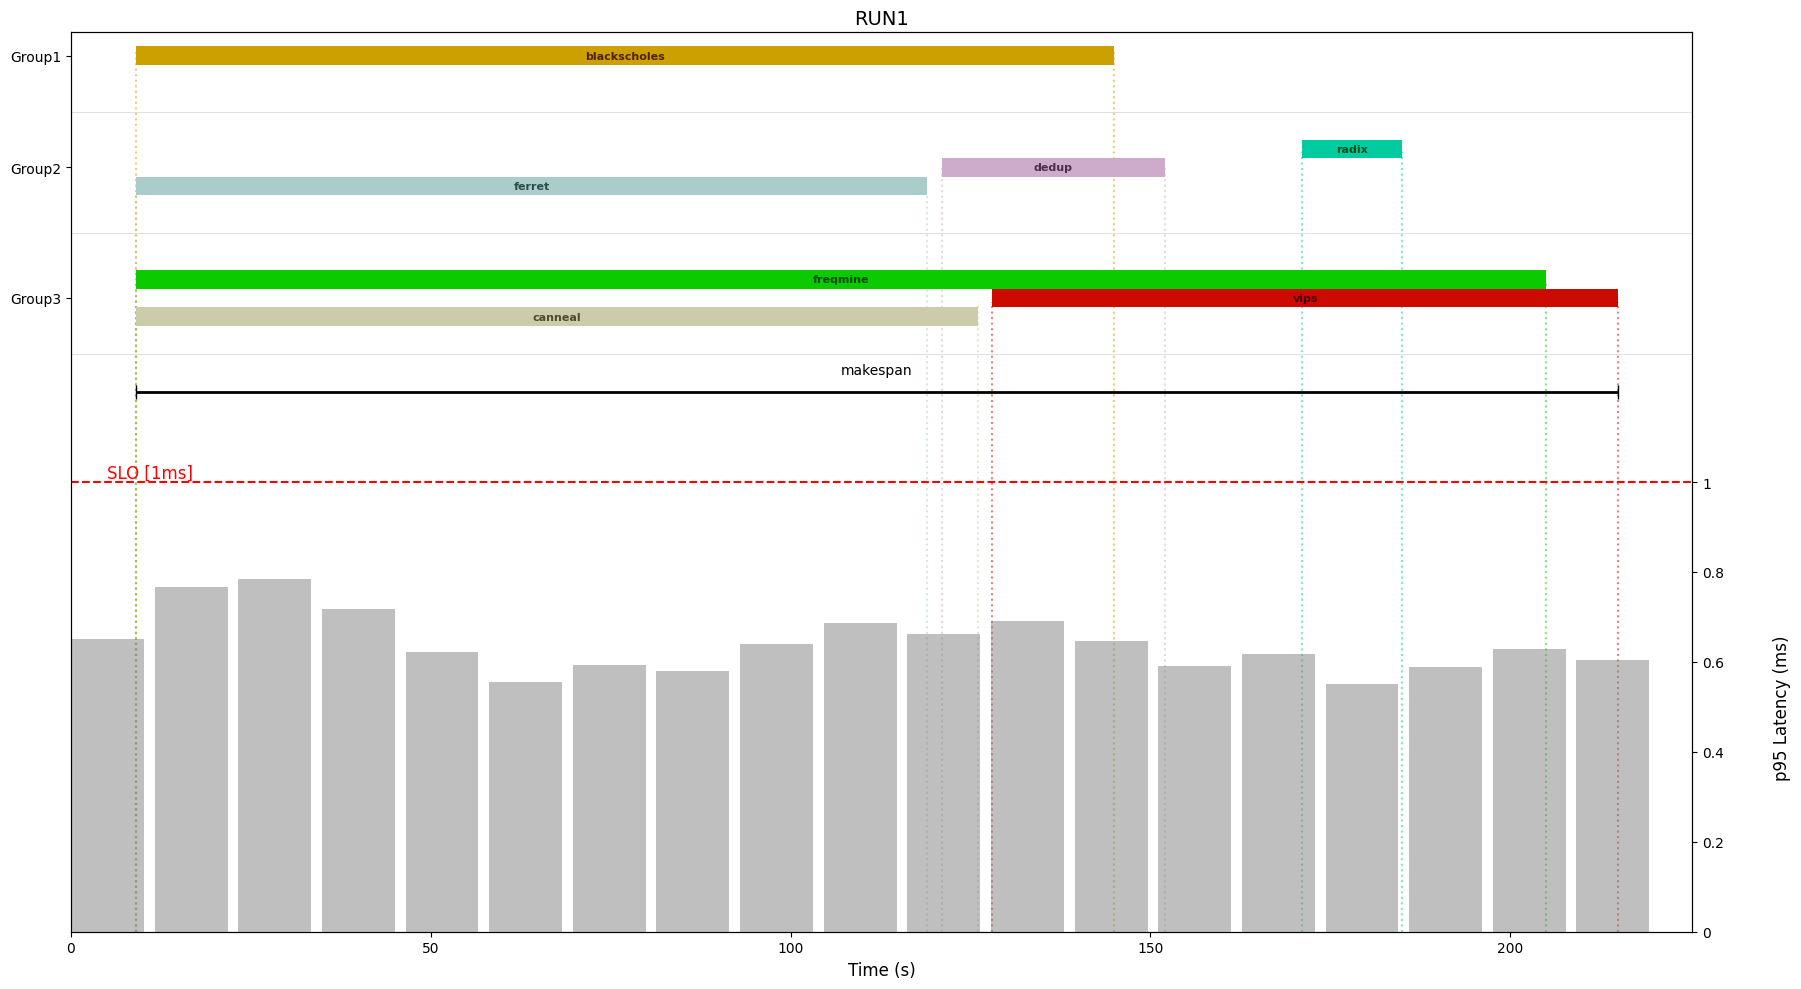

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3487600983.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3487600983.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


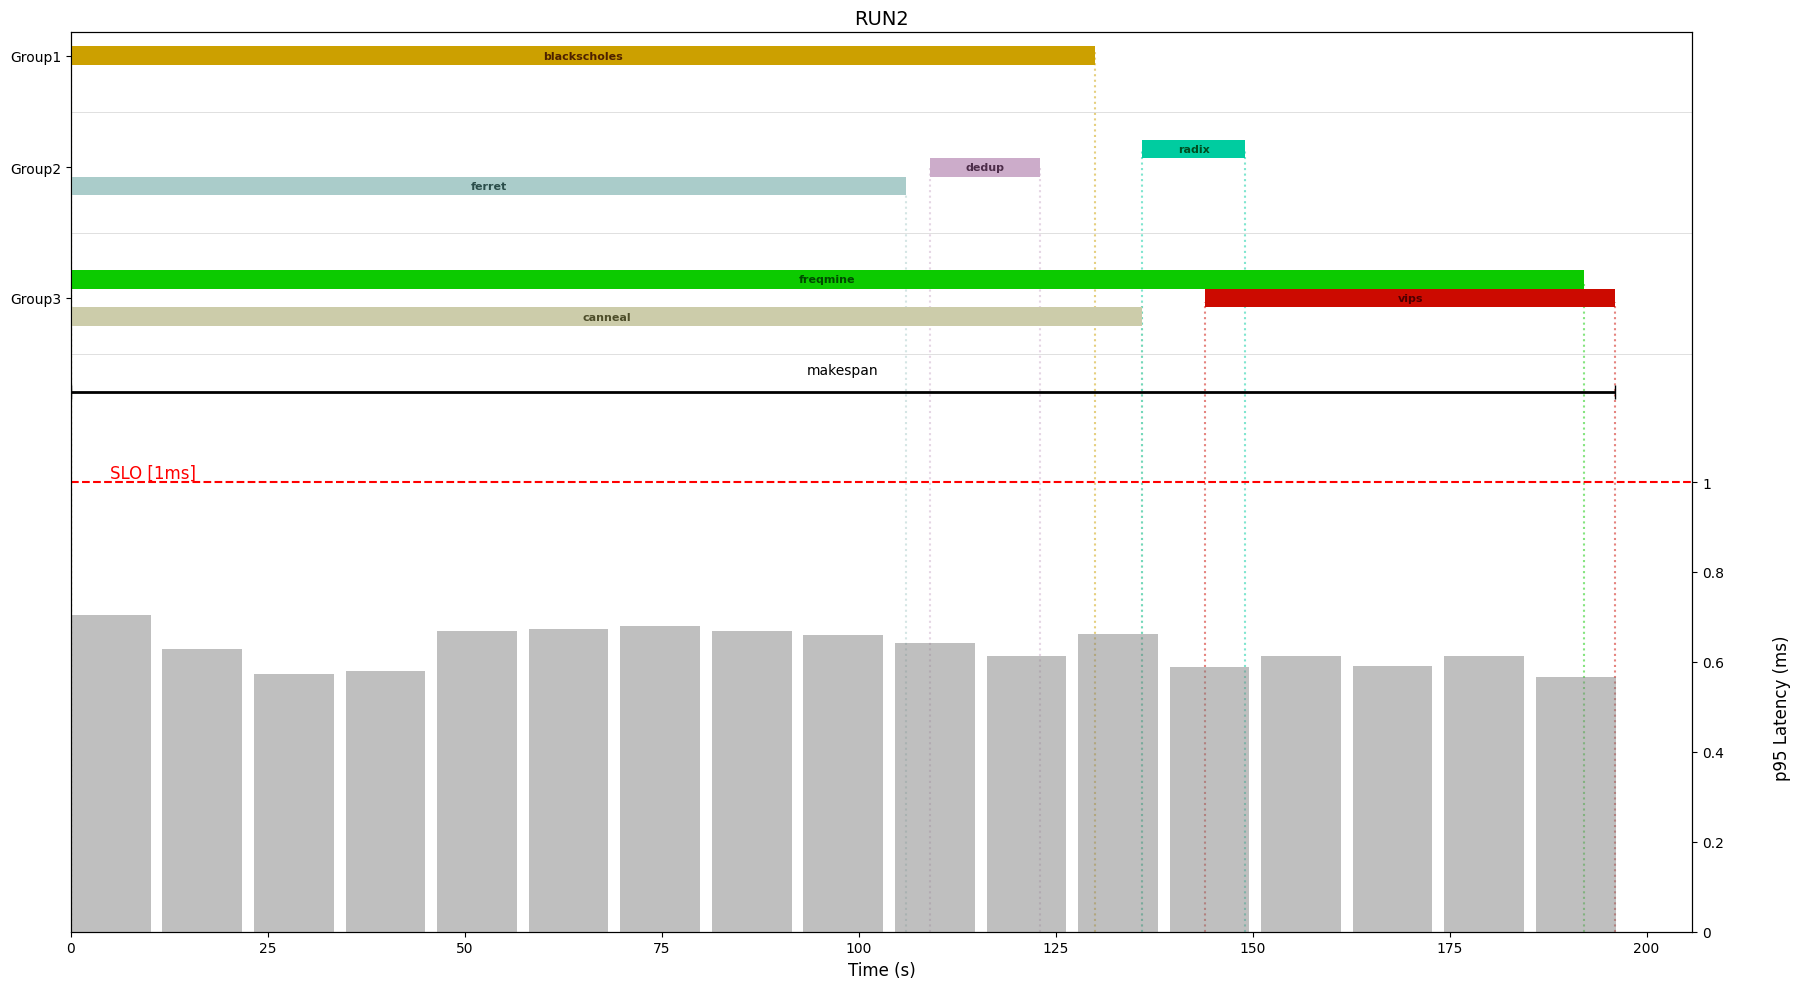

/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3487600983.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
/var/folders/8w/nwb14j3528z683xrv4rw0j4r0000gn/T/ipykernel_19699/3487600983.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()


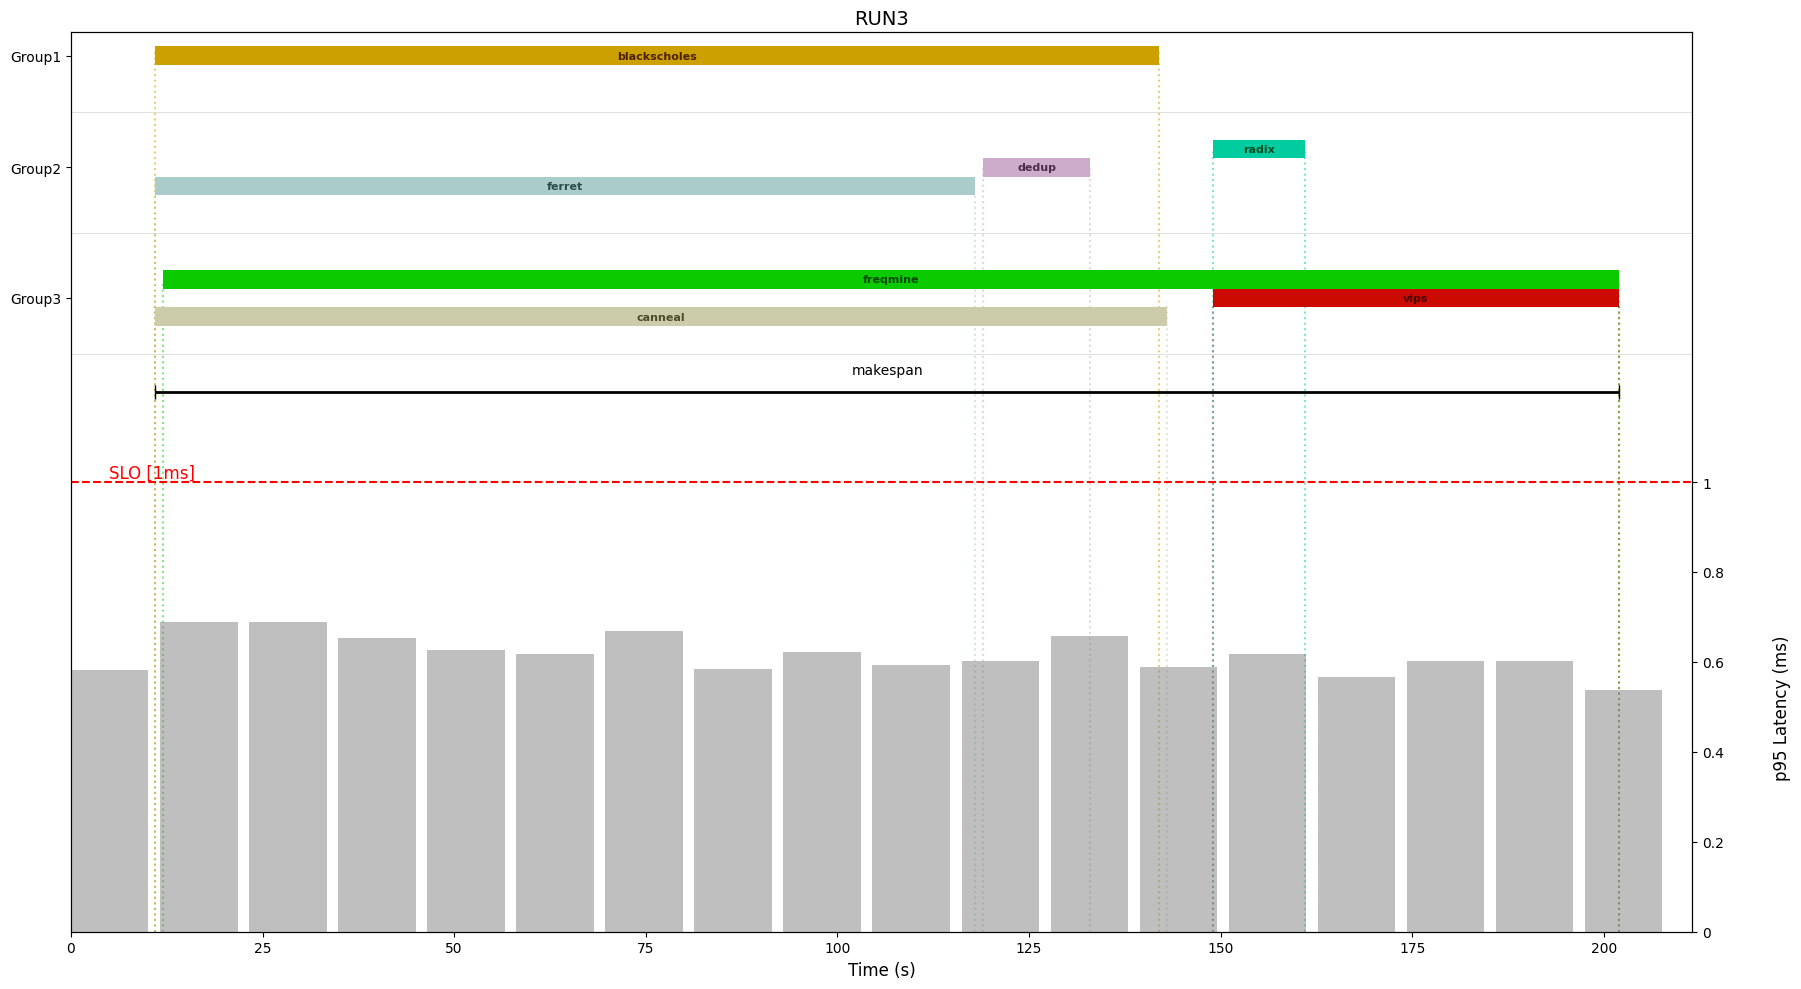

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

job_colors = {
    'parsec-blackscholes': '#CCA000',
    'parsec-canneal': '#CCCCAA',
    'parsec-dedup': '#CCACCA',
    'parsec-ferret': '#AACCCA',
    'parsec-freqmine': '#0CCA00',
    'parsec-radix': '#00CCA0',
    'parsec-vips': '#CC0A00'
}
job_lim = {
    'parsec-blackscholes': 0.98,
    'parsec-canneal': 0.7,
    'parsec-dedup': 0.85,
    'parsec-ferret': 0.82,
    'parsec-freqmine': 0.72,
    'parsec-radix': 0.87,
    'parsec-vips': 0.7
}
def darken_color(color):
    # Convert the color to RGB values
    r, g, b = colors.to_rgb(color)

    # Darken the color by reducing each RGB component
    new_r = max(0, r - 0.5)
    new_g = max(0, g - 0.5)
    new_b = max(0, b - 0.5)

    # Create the darker color
    darker_color = (new_r, new_g, new_b)

    return darker_color

def plot_combined_plot(mcperf_df, pods_df, run_folder, dist):
    fig, ax1 = plt.subplots(figsize=(18, 10))

    job_groups = {
        'Group3': ['parsec-canneal', 'parsec-vips','parsec-freqmine'],
        'Group2': ['parsec-ferret', 'parsec-dedup', 'parsec-radix'],
        'Group1': ['parsec-blackscholes'],
    }
    vertical_spacing = 1.0 
    y_positions = {'Group3': 3.0, 'Group2': 10.0, 'Group1': 17.0}
    maxt = 0
    for group_name, group_jobs in job_groups.items():
        for job in group_jobs:
            row = pods_df[pods_df['Job'] == job].iloc[0]
            if row['Job'] in job_colors:
                color = job_colors[row['Job']]
                limit = job_lim[row['Job']]
                if row['End Time'] > maxt:
                    maxt = row['End Time']
                ax1.barh(y=y_positions[group_name], left=row['Start Time']+dist.total_seconds(), width=row['End Time'] - row['Start Time'], height=1, color=color, zorder=3)

                text_x = (row['Start Time']+dist.total_seconds() + row['End Time']+dist.total_seconds()) / 2  
                text_y = y_positions[group_name]
                ax1.text(text_x, text_y, job[7:], ha='center', va='center', color=darken_color(color), fontsize=8, fontweight='bold')
                ax1.axvline(x=row['Start Time']+dist.total_seconds(), ymin=0,ymax=limit,color=color, linestyle=':', alpha=0.5)
                ax1.axvline(x=row['End Time']+dist.total_seconds(),  ymin=0,ymax=limit,color=color, linestyle=':', alpha=0.5)

                y_positions[group_name] += 1 
        
    ax1.set_ylim(-30)
    ax1.set_yticks([4.0, 11.0, 17.0])
    ax1.set_yticklabels(list(job_groups.keys()))

    tray_y_positions = [1.0, 7.5, 14.0]
    for y_pos in tray_y_positions:
        ax1.axhline(y=y_pos, color='lightgray', linewidth=0.5)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_xlim(0)
    mcperf_df['width'] = mcperf_df['ts_end'] - mcperf_df['ts_start']
    mcperf_df['left'] = mcperf_df['ts_start'] - mcperf_df['ts_start'].min()
    ax2 = ax1.twinx()
    ax2.bar(mcperf_df['left'], mcperf_df['p95'], width=mcperf_df['width'], align='edge', color='grey', alpha=0.5)

    ax2.axhline(y=1, color='red', linestyle='--', label='1 ms')
    if run_folder == 'run3':
        ax2.text(5, 1, 'SLO [1ms]', color='red', fontsize=12, verticalalignment='bottom')
    else:
        ax2.text(5, 1, 'SLO [1ms]', color='red', fontsize=12, verticalalignment='bottom')

    ax2.hlines(y=1.2, xmin=dist.total_seconds(), xmax=maxt+ dist.total_seconds(), color='black', linewidth=2 )
    ax2.text((dist.total_seconds() + maxt+ dist.total_seconds()) / 2, 1.25, 'makespan', horizontalalignment='center', verticalalignment='center')

    ax2.plot(dist.total_seconds(), 1.2, marker='|', markersize=10, color='black')
    ax2.plot(maxt+ dist.total_seconds(), 1.2, marker='|', markersize=10, color='black')
    ax2.set_ylabel('p95 Latency (ms)', fontsize=12)
    ax2.yaxis.set_label_coords(1.05,0.25)
    ax2.set_title(f'{run_folder}'.upper(), fontsize=14)

    ax2.set_ylim(0, 2) 
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
    ax2.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], fontsize=10)
     


    plt.tight_layout()
    plt.show()

for i, run_folder in enumerate(['run1', 'run2', 'run3']):
    plot_combined_plot(all_mcperf_data2[i], all_pods_data[i], run_folder, distances[i])
